In [1]:
from BPTK_Py import Model, bptk
from pygments.lexers import resource

#https://bptk.transentis.com/tutorials/system_dynamics/sd_tutorial.html
#https://bptk.transentis.com/quickstart/quickstart.html
#https://medium.com/@shouke.wei/python-system-dynamics-from-vensim-diagrams-to-running-code-in-minutes-4769a48f389d

In [2]:
# 1) Model initialization

model = Model(
    starttime=0.0,
    stoptime=20.0,
    dt=0.25,        # statt 1.0
    name="Ants"
)

In [3]:
# 2) Stocks + initial values

ant_colonies = model.stock("Ameisen")                   #Ameisen
ant_colonies.initial_value = 20.0                       #Anzahl
invasive = model.stock("Invasive Ameisen")              #Invasive Ameisen
invasive.initial_value = 1.0                            #Anzahl
#ant_collonies.equation = -(17/30) * invasive
habitat = model.stock("Habitatsqualität")               #Habitatsqualität
habitat.initial_value = 100.0                           #Prozentanzahl
resources = model.stock("Ressourcen für invasive Art")  #Ressourcen für invasive Art
resources.initial_value = 100.0                         #Prozentanzahl
climate_change = model.stock("Erderwärmung")            #Erderwärmung
climate_change.initial_value = 1.6                      #in Grad
climate_change_increase = model.stock("Erhöhung pro Jahr")
climate_change_increase.initial_value = 0.025

In [4]:
# 3) Flows

ant_growth = model.flow("ant_growth")                       #Lebensraumqualität für einheimische Ameisen
invasive_growth = model.flow("invasive_growth")             #Ressourcen
resource_consumption = model.flow("resource_consumption")   #Verbrauchte Ressourcen
habitat_change = model.flow("habitat_change")               #Veränderung
habitat_loss = model.flow("habitat_loss")                   #Verschlechtert Habitatsqualität

ant_loss = model.flow("ant_loss")                 # neuer Abfluss Ameisen
invasive_loss = model.flow("invasive_loss")       # neuer Abfluss Invasive
habitat_regen = model.flow("habitat_regen")       # neuer Regenerationsfluss Habitat
resource_regen = model.flow("resource_regen")     # optional: Regeneration Ressourcen


In [5]:
# 4) Equations

# jedes Jahr werden 25 % von den Ressourcen von den Ameisen gebraucht
resource_consumption.equation = ant_colonies * 0.25

# Regeneration der Ressourcen abhängig von den noch vorhandenen Ressourcen, bei +0.4/Jahr
resource_regen.equation = (100.0 - resources) * 0.4   # ρ_R = 0.4/Jahr

# Veränderung der invasiven Art abhängig von den Ressourcen, Eigenwachstum und Mortalitaet
#invasive_growth.equation = resources * 0.01
invasive_growth.equation = invasive * 0.8 * (resources / (resources + 20.0))
invasive_loss.equation   = invasive * 0.4

# Wenn 1 Grad Erderwärmung eine Verschlechterung der Habitatsqualität um 1 % bedeutet + Einfluss der invasiven Arten auf Habitat bei -1 %:
#habitat_loss.equation = climate_change
#habitat_change.equation = invasive * 0.01
habitat_regen.equation   = (100.0 - habitat) * 0.5
habitat_loss.equation    = climate_change * 2.0
habitat_change.equation  = invasive * 0.01

# Einfluss von Habitat auf Ameisengrösse bei +2 %
#ant_growth.equation = habitat * 0.02
ant_growth.equation = ant_colonies * 0.6 * (habitat / (habitat + 30.0))
ant_loss.equation   = ant_colonies * 0.3

In [6]:
# 5) Verknüpfung

#ant_colonies.equation = ant_growth - (invasive * (17/35)) # 1 invasive Art verdrängt 17 lokale in 35 Jahren https://publikationen.badw.de/de/044676698/044676698%5BCC%20BY-ND%5D%7B07%20Cremer%20(Invasive%20Ameisen%20in%20Europa%20...)%7D.pdf
#resources.equation = -resource_consumption
#invasive.equation = invasive_growth
#habitat.equation = -(habitat_loss + habitat_change)
ant_colonies.equation = ant_growth - ant_loss - (invasive * (17/35))
invasive.equation     = invasive_growth - invasive_loss
habitat.equation      = habitat_regen - (habitat_loss + habitat_change)
resources.equation    = resource_regen - resource_consumption
climate_change.equation = climate_change_increase #eine Erwärmung um 0,25 °C pro Dekade #https://www.umweltbundesamt.de/themen/klima-energie/klimawandel/zu-erwartende-klimaaenderungen-bis-2100


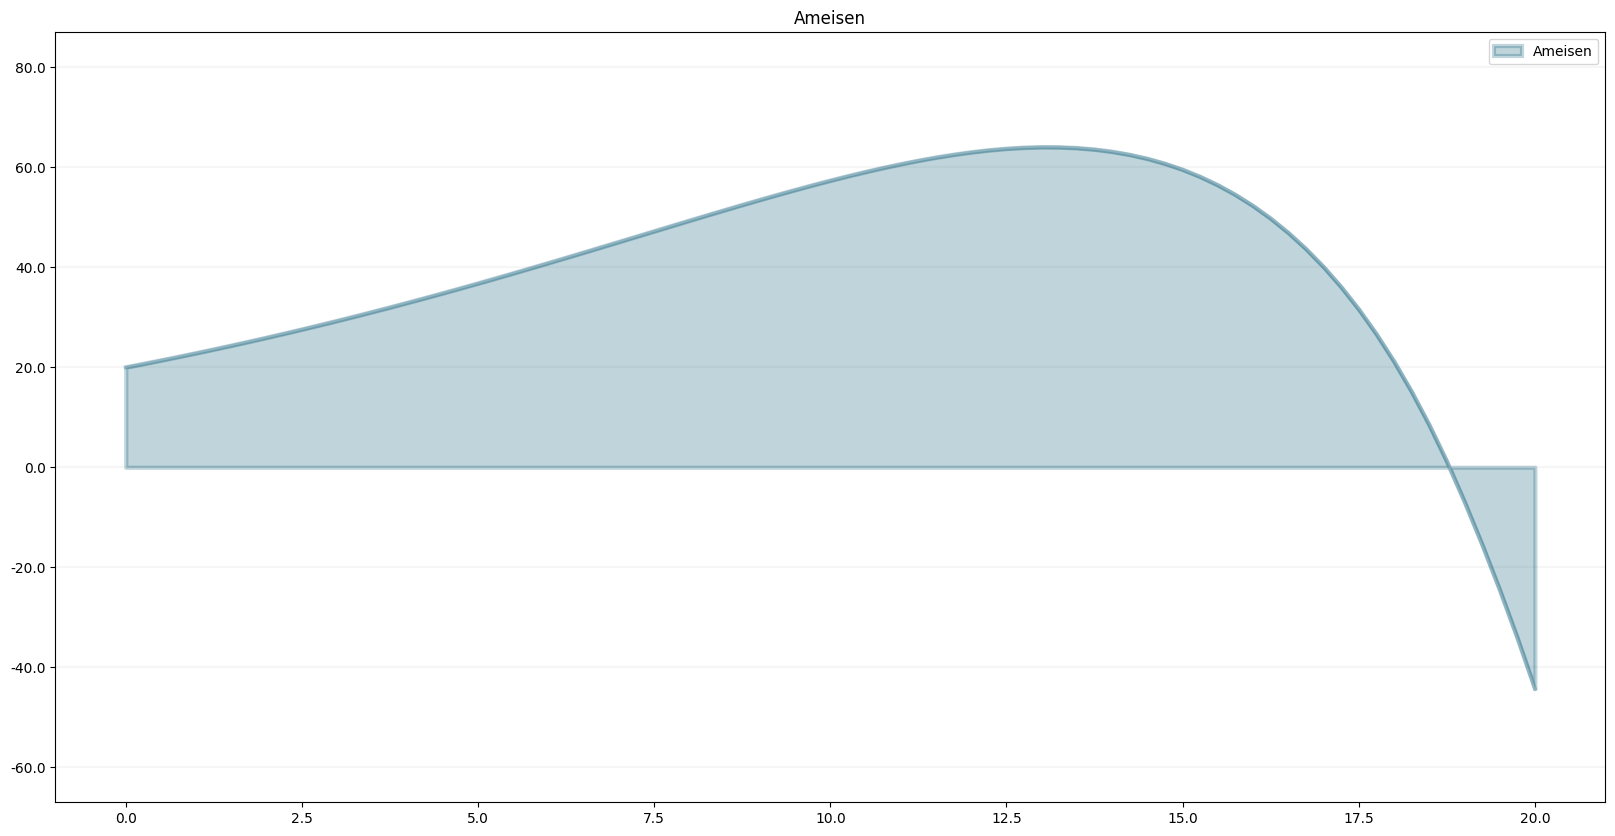

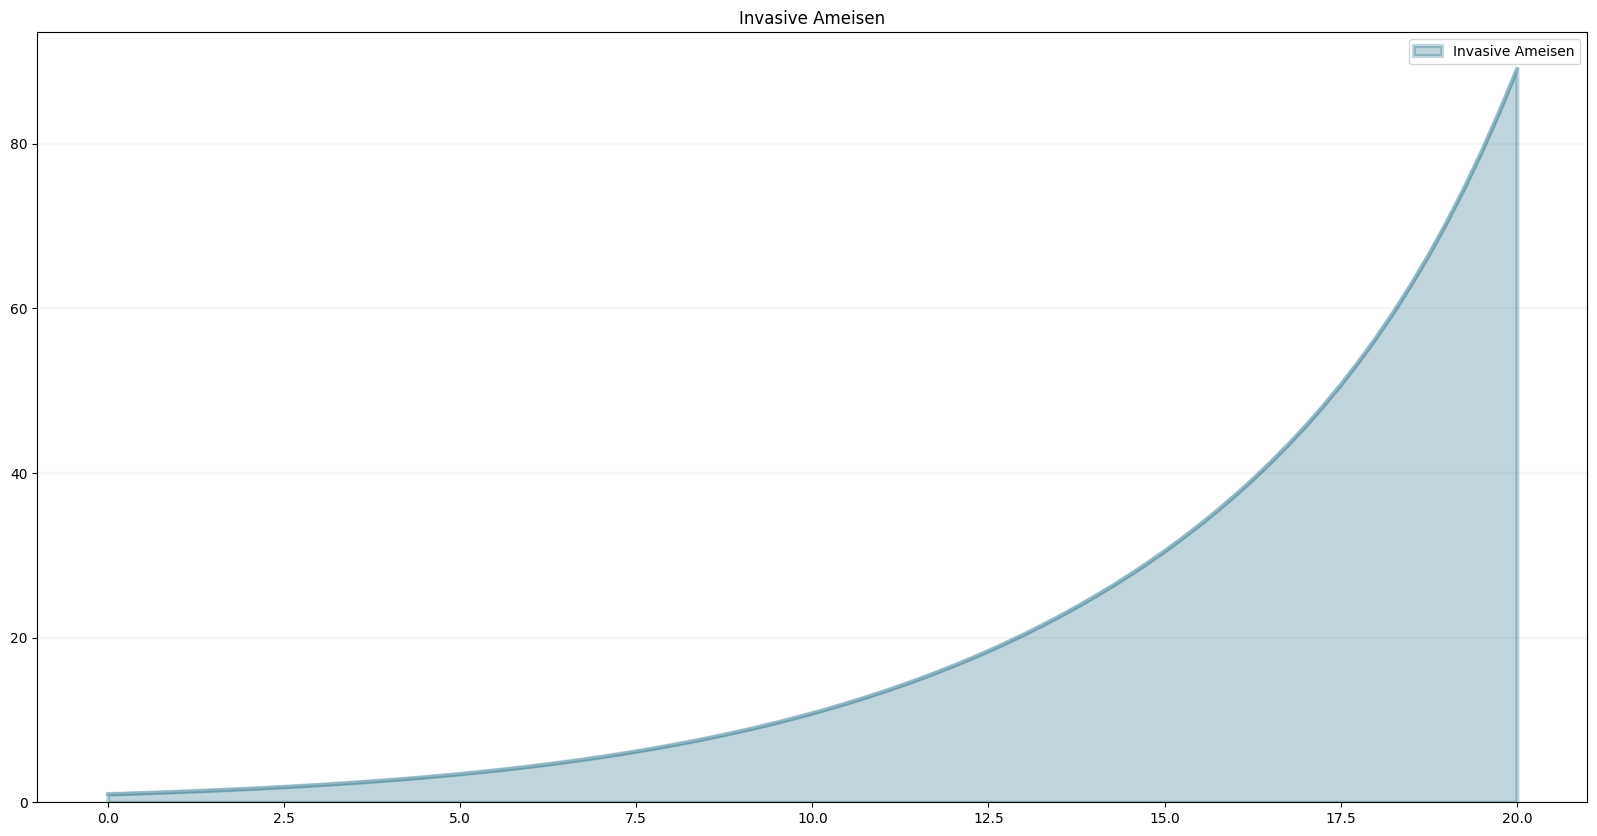

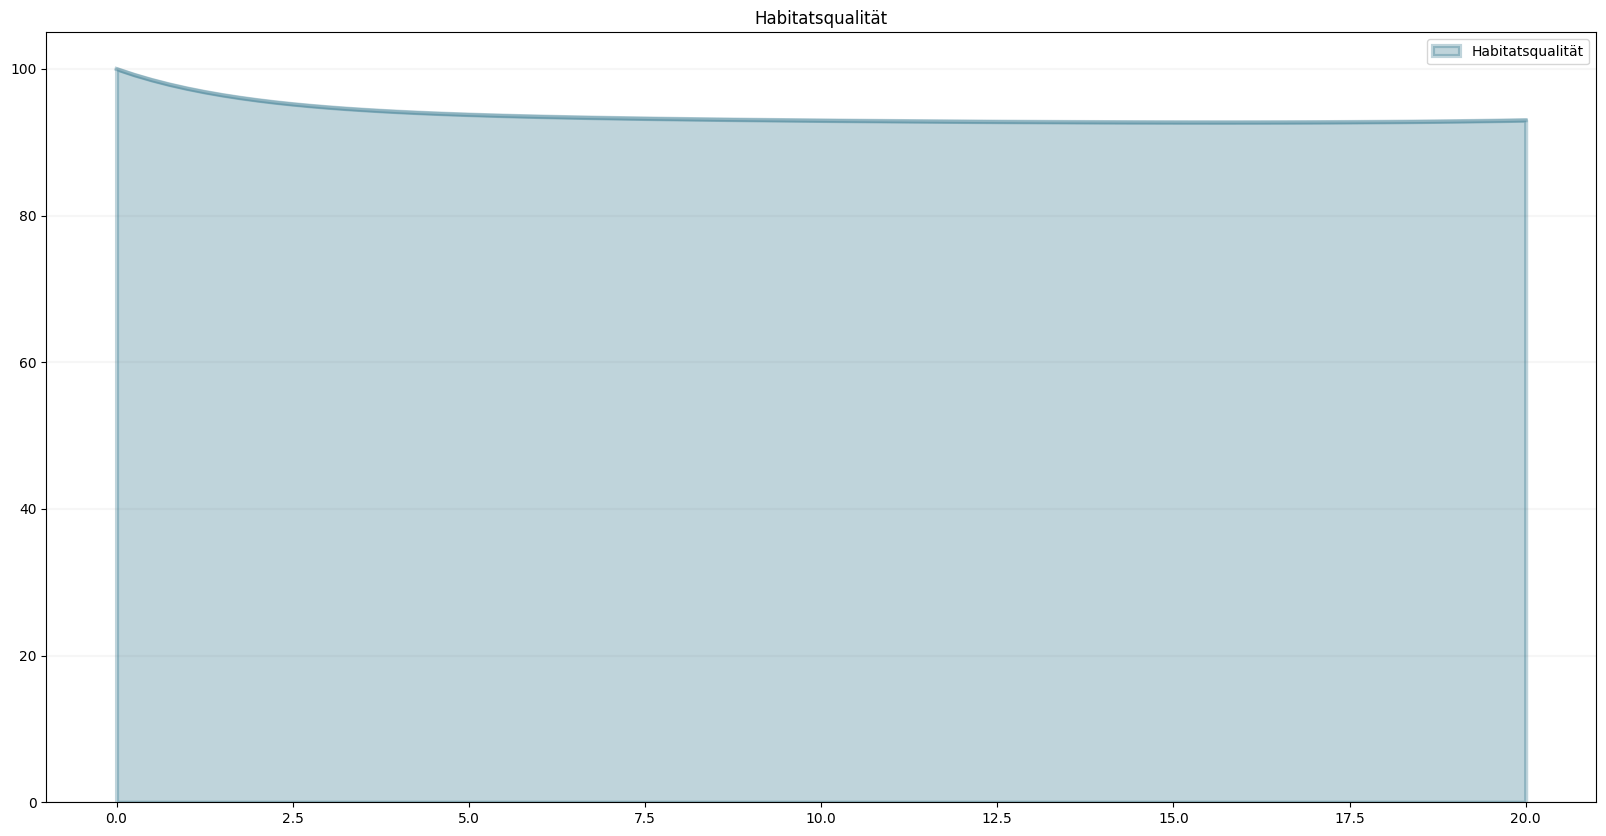

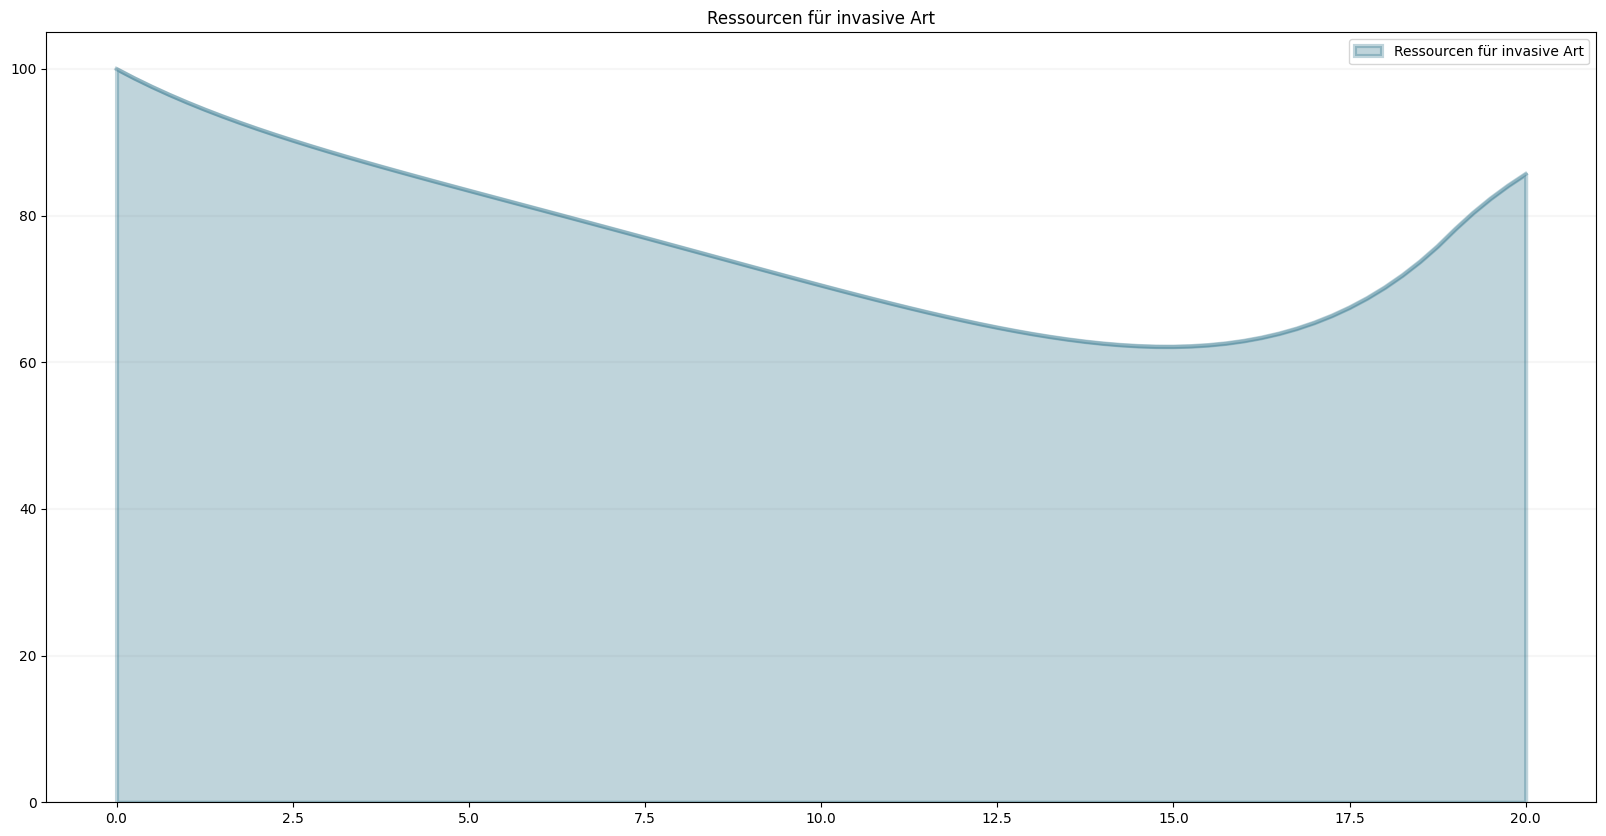

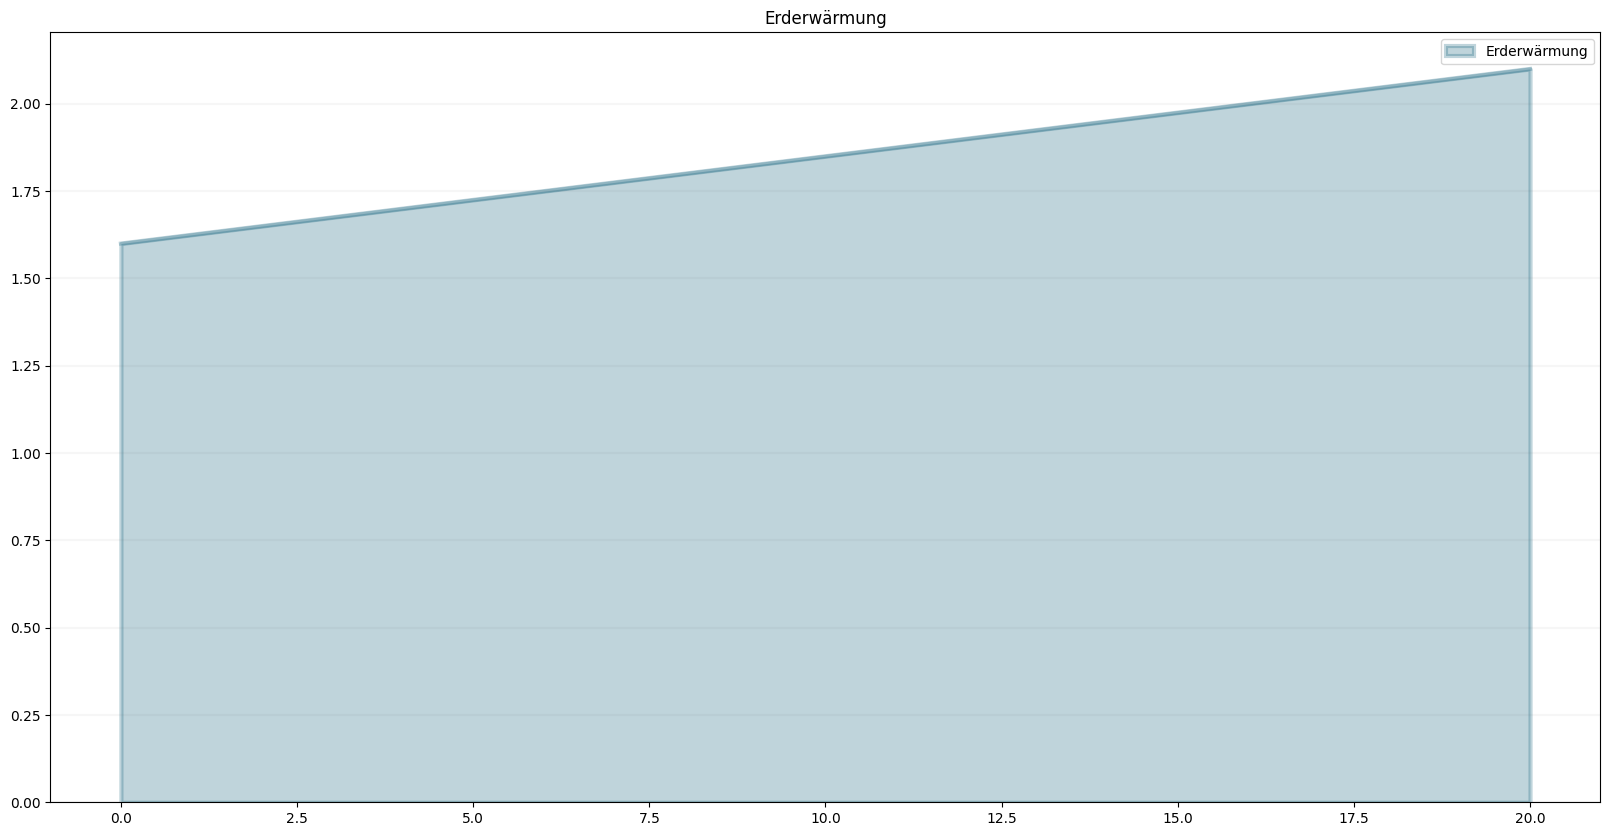

In [7]:
ant_colonies.plot()
invasive.plot()
habitat.plot()
resources.plot()
climate_change.plot()

In [8]:
bptk = bptk()

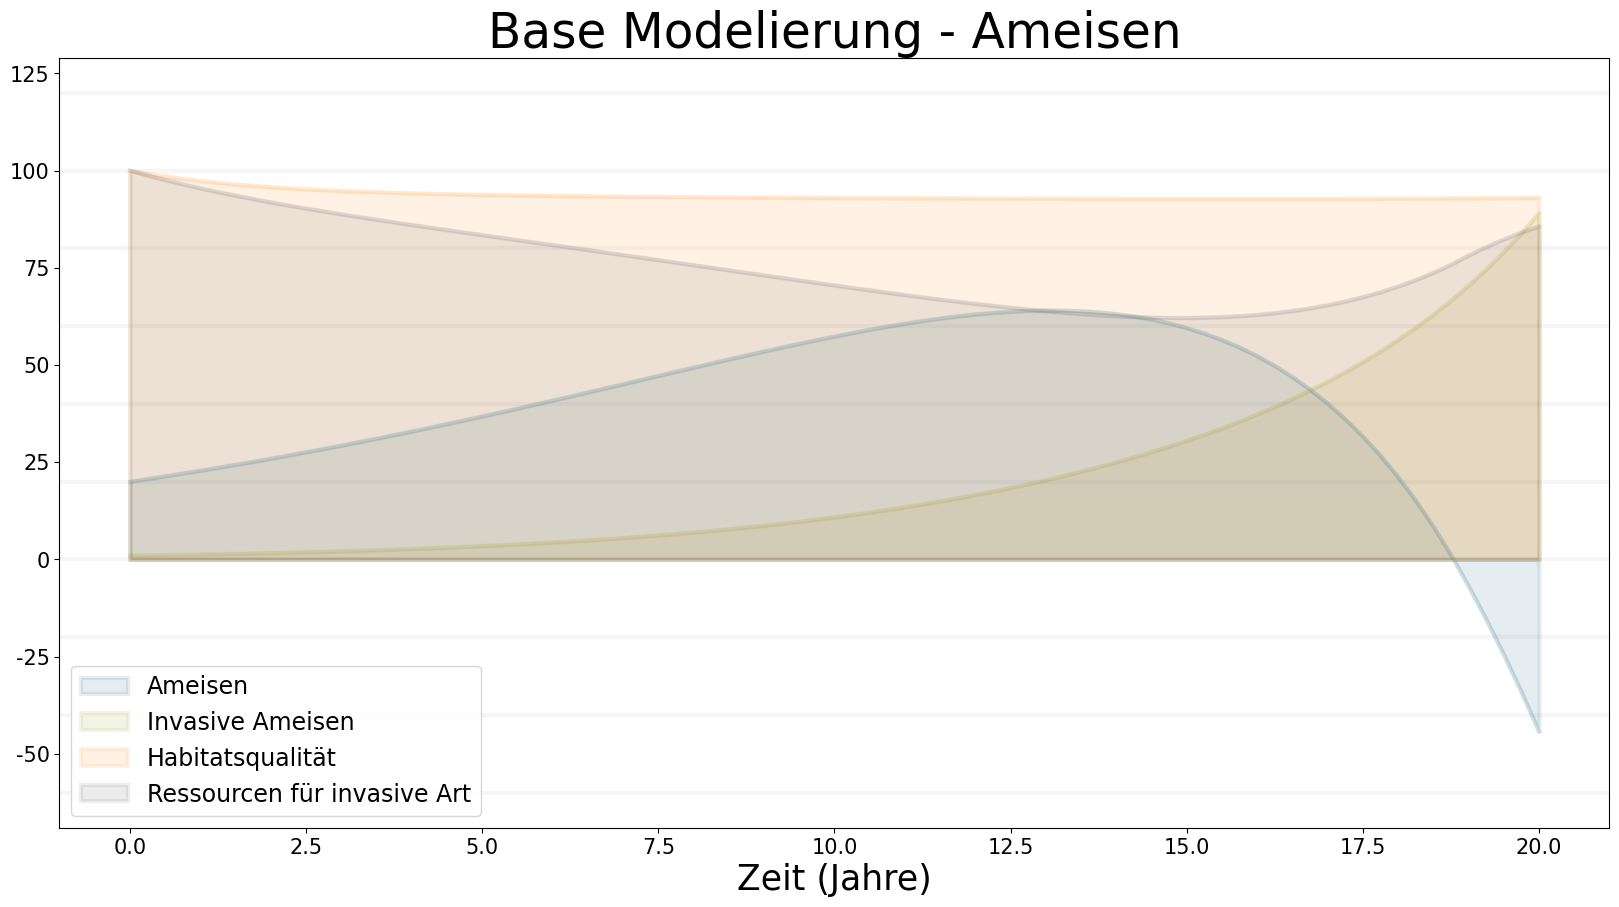

In [9]:
bptk.register_model(model)

bptk.plot_scenarios(
    scenarios="base",
    scenario_managers="smAnts",
    equations=[
        "Ameisen",
        "Invasive Ameisen",
        "Habitatsqualität",
        "Ressourcen für invasive Art"
    ],
    alpha=0.1,
    title="Base Modelierung - Ameisen",
    x_label="Zeit (Jahre)"
)

**Verschiedener Szenarien der Veränderung der Erderwärmung im Jahr:**

In [10]:
scenario_manager = {
    "smAnts":{
        "model": model,
        "base_constants": {
            "ant_colonies": 20.0,
            "invasive": 1.0,
            "habitat": 100.0,
            "resources": 100.0,
            "climate_change": 1.6,
            "climate_change_increase": 0.025
        }
    }
}

bptk.register_scenario_manager(scenario_manager)

In [11]:
bptk.register_scenarios(
    scenario_manager="smAnts",
    scenarios = {
        "increase_0.05C": {
            "constants": {
                "Erhöhung pro Jahr": 0.05
            }
        }
    })

bptk.register_scenarios(
    scenario_manager="smAnts",
    scenarios = {
        "increase_0.1C": {
            "constants": {
                "Erhöhung pro Jahr": 0.1
            }
        }
    })

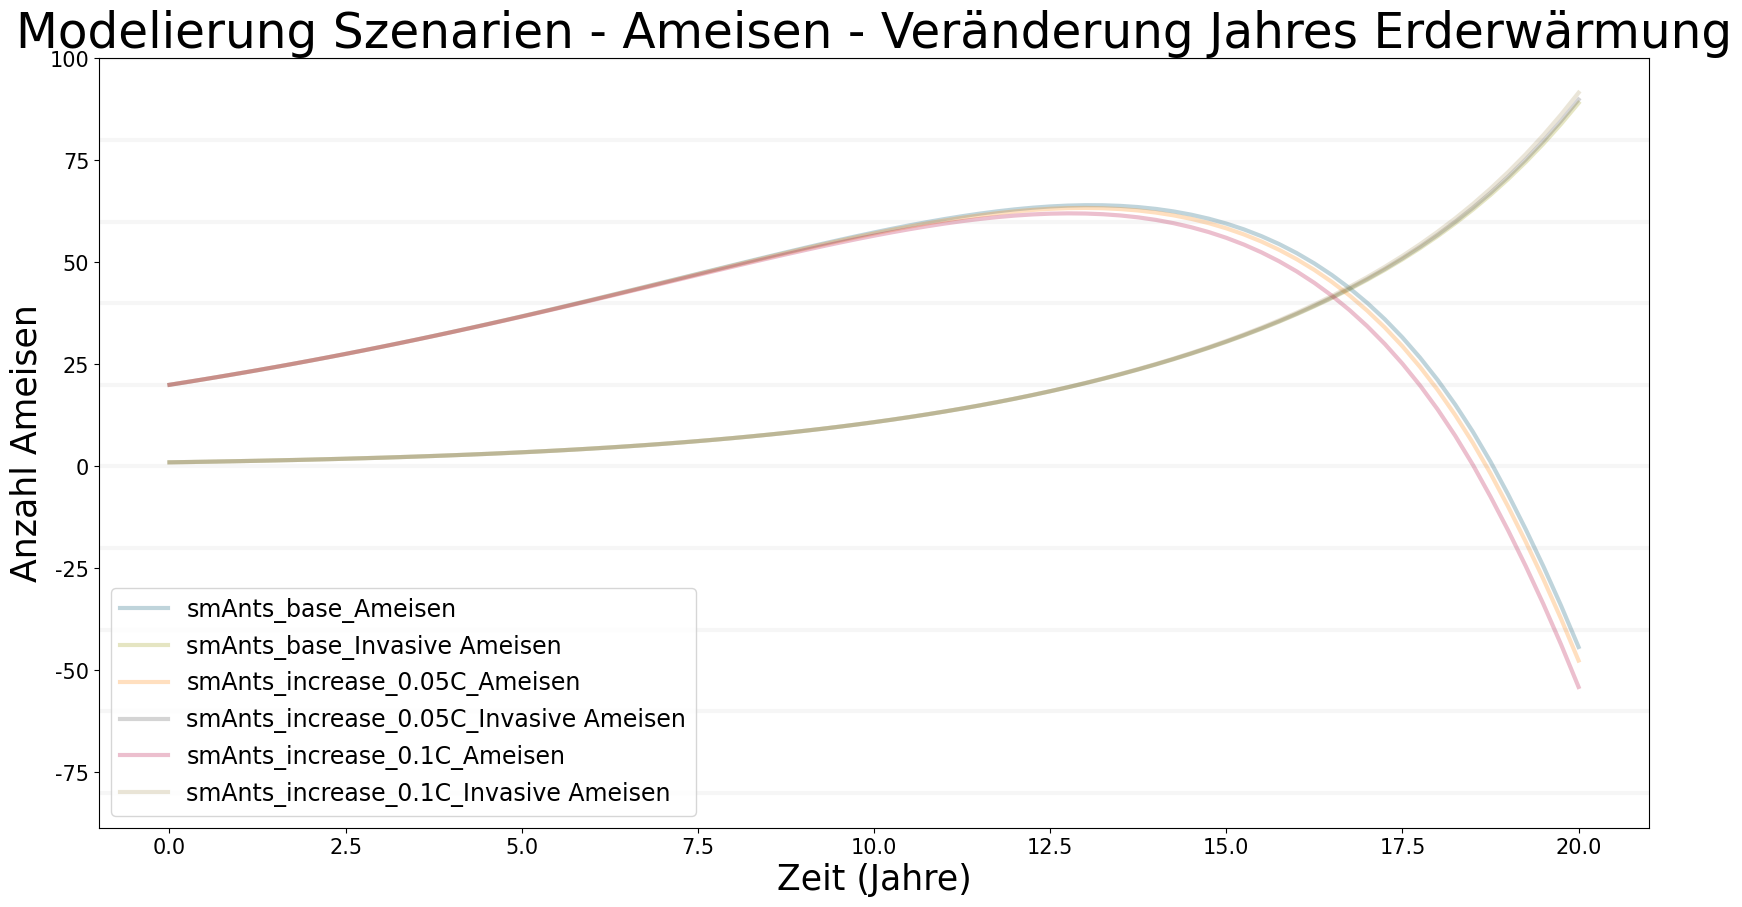

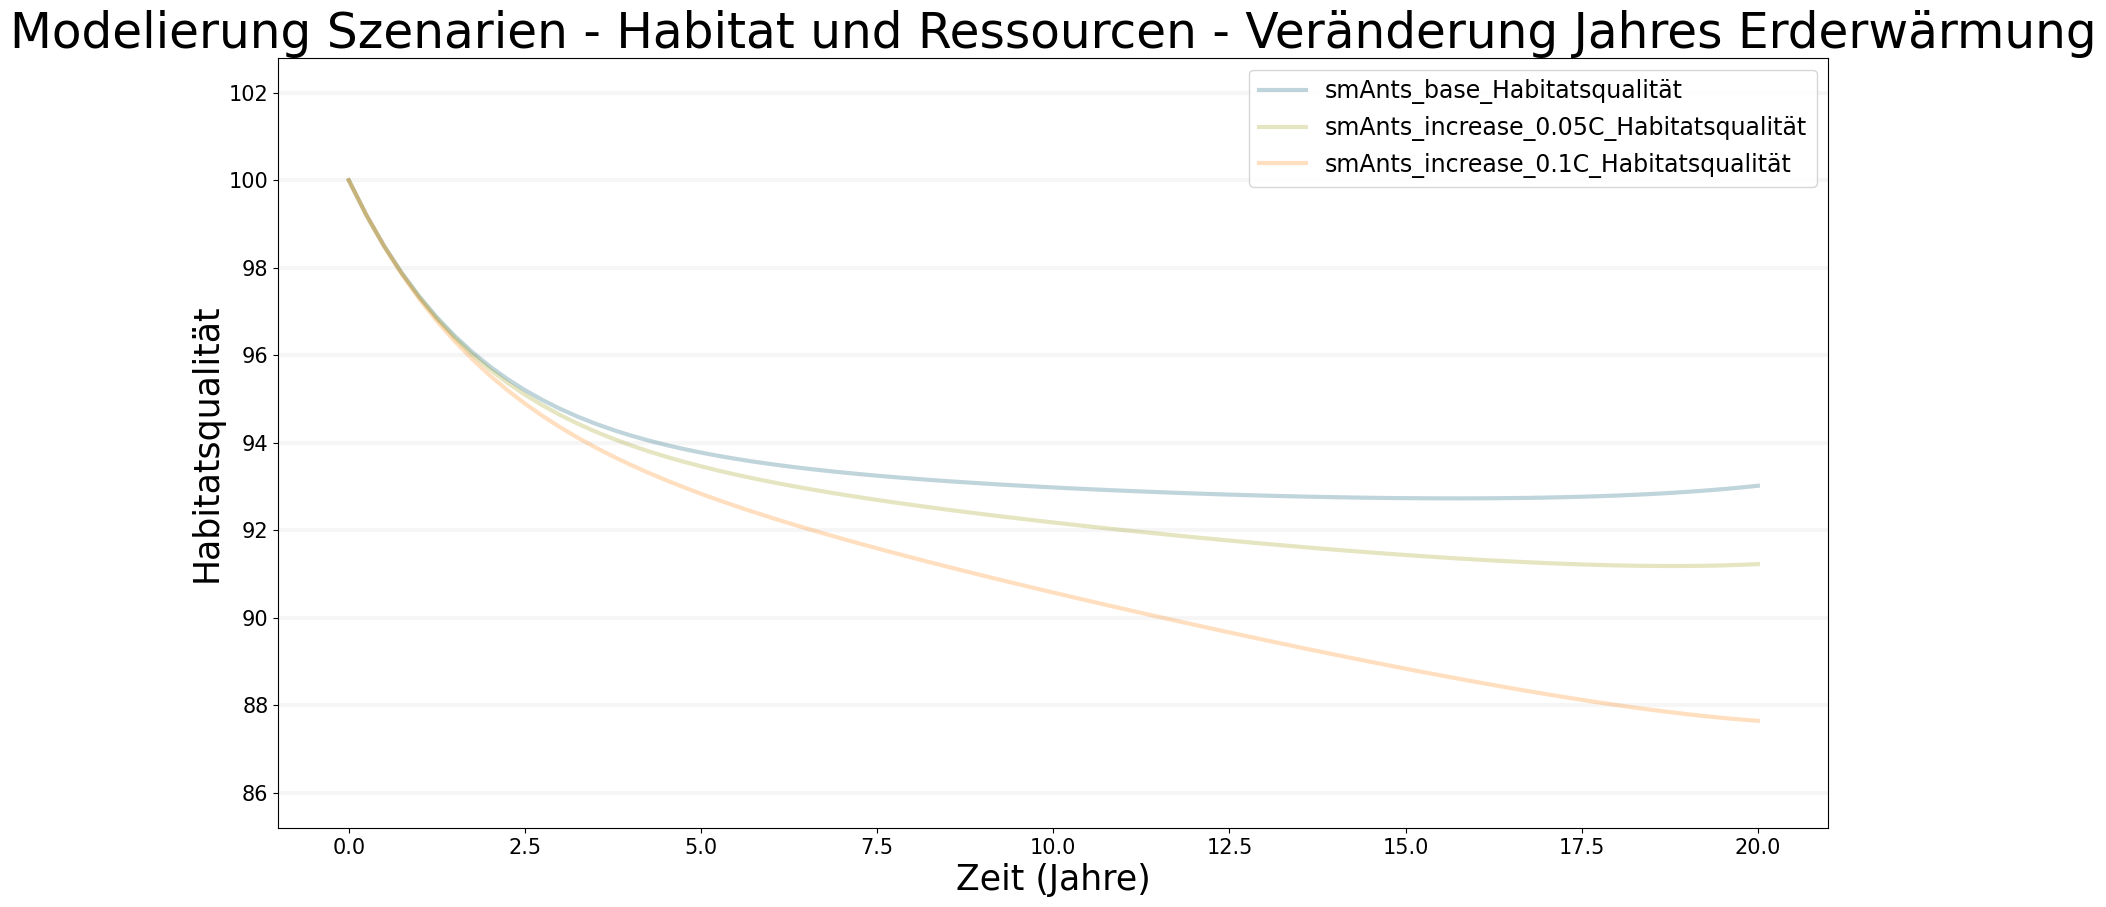

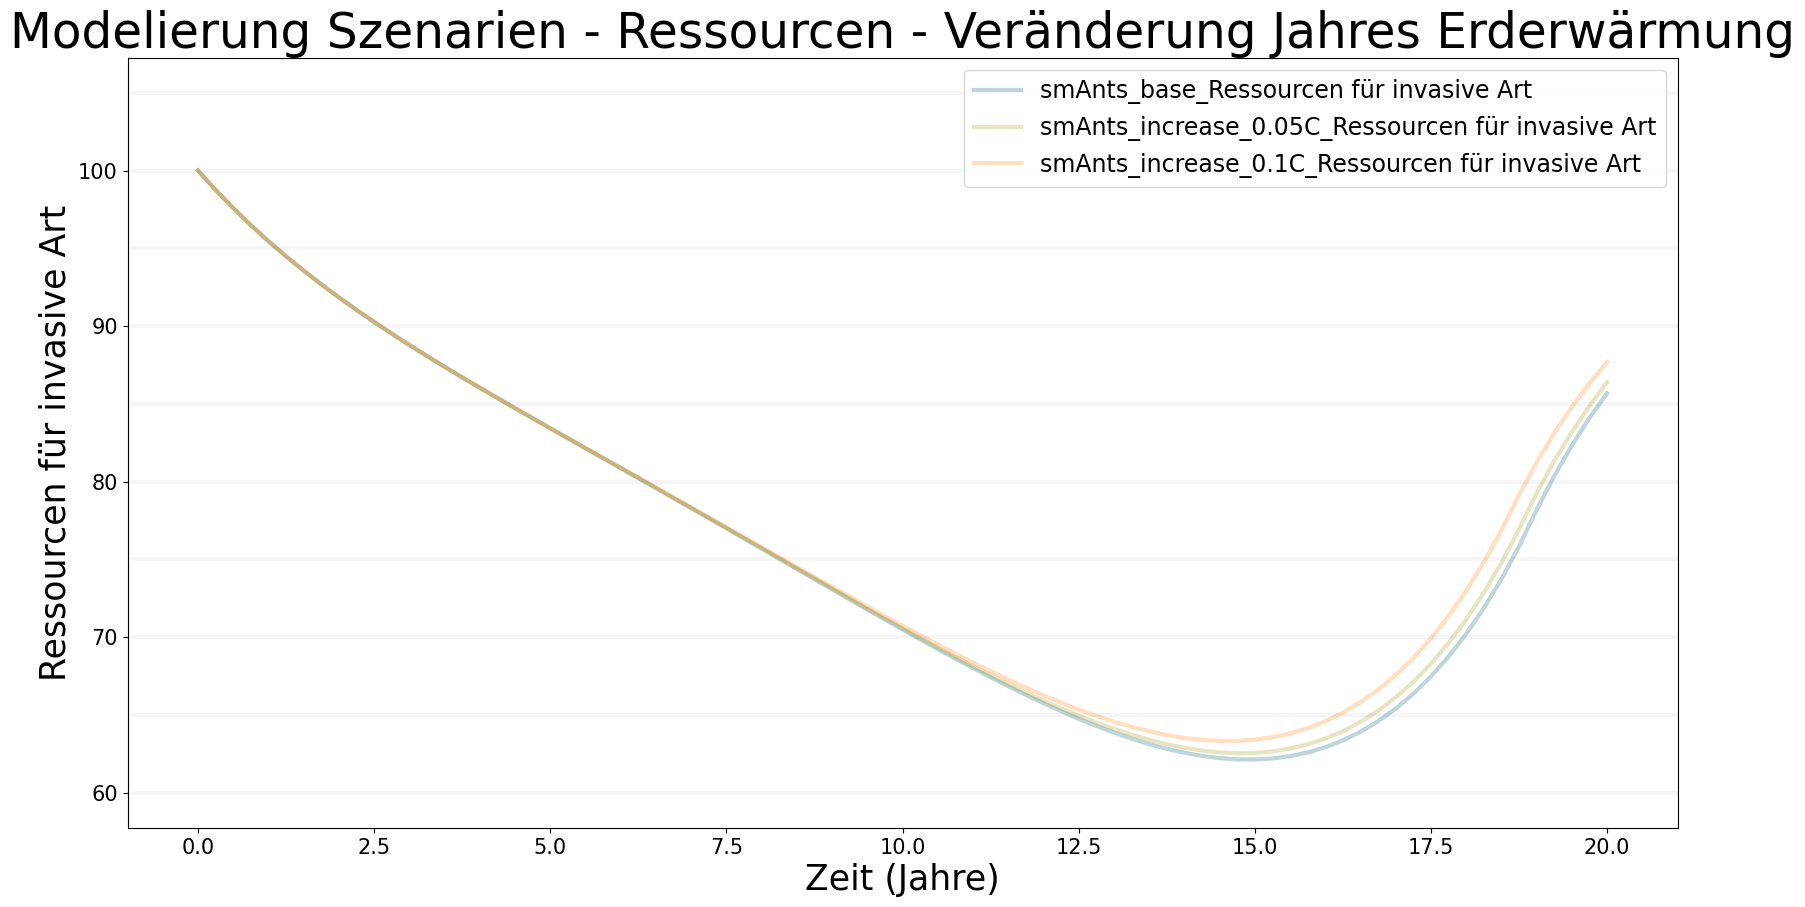

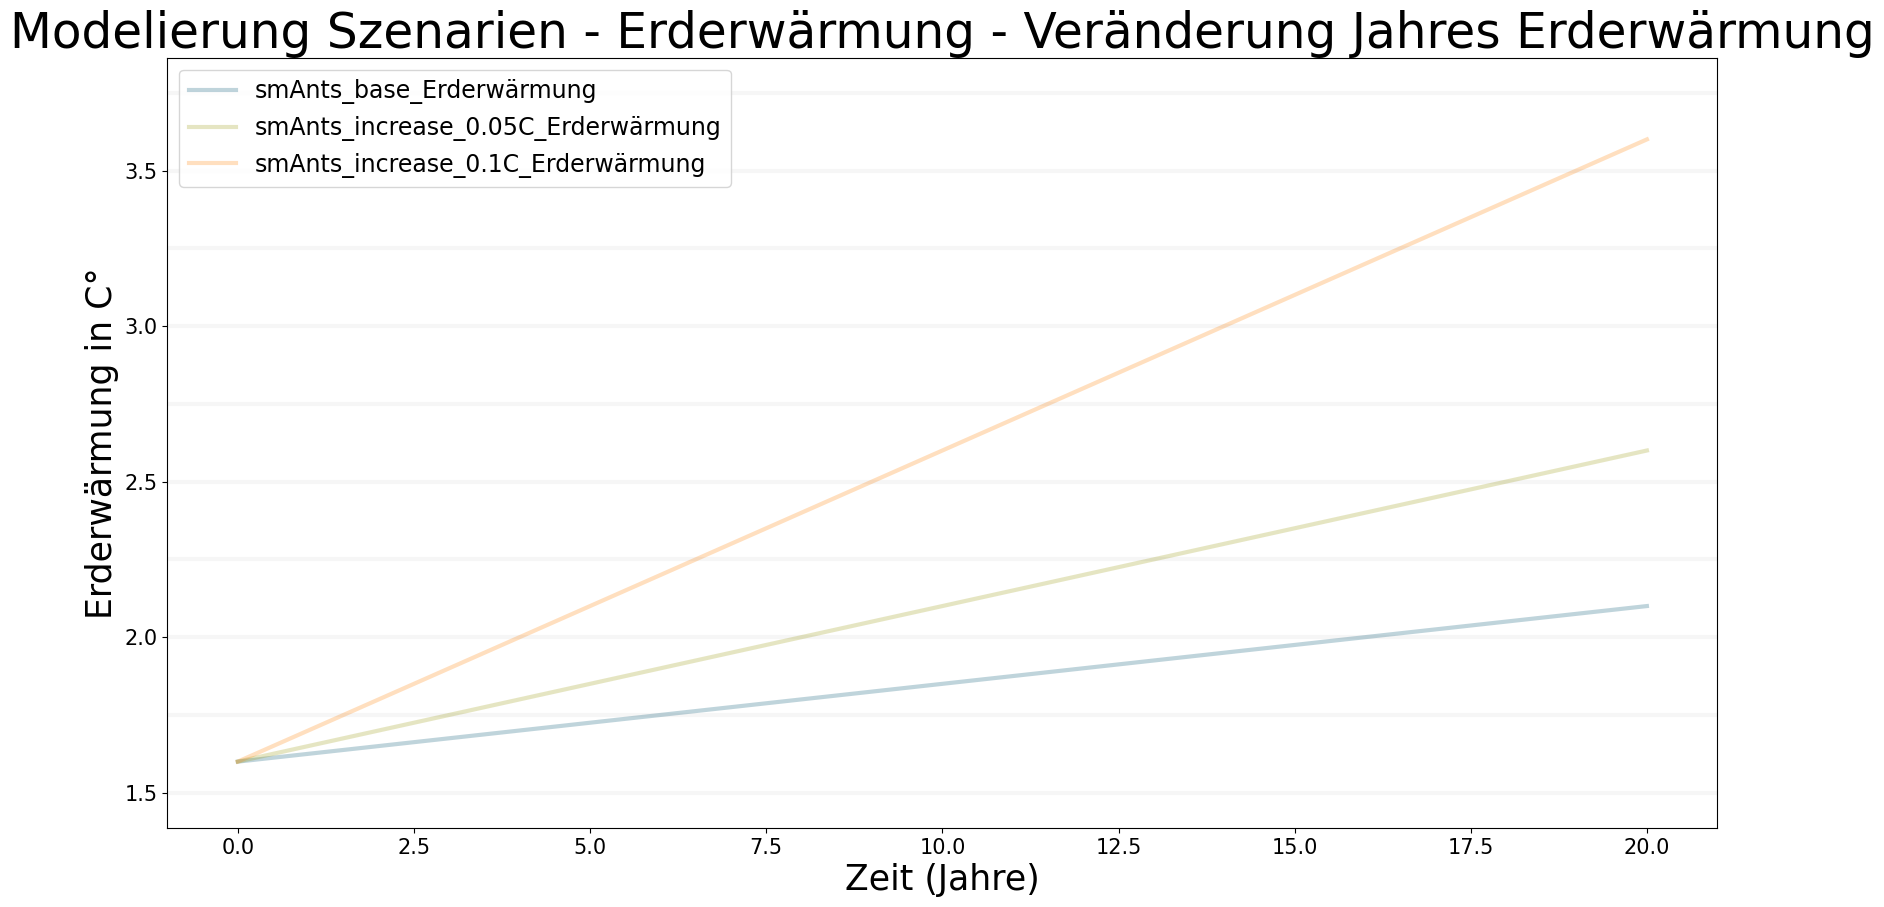

In [12]:
bptk.plot_scenarios(
    scenarios=["base", "increase_0.05C", "increase_0.1C"],
    scenario_managers="smAnts",
    equations=["Ameisen", "Invasive Ameisen"],
    series_names={},
    kind="line",
    title="Modelierung Szenarien - Ameisen - Veränderung Jahres Erderwärmung",
    x_label="Zeit (Jahre)",
    y_label="Anzahl Ameisen"
)

bptk.plot_scenarios(
    scenarios=["base", "increase_0.05C", "increase_0.1C"],
    scenario_managers="smAnts",
    equations=["Habitatsqualität"],
    series_names={},
    kind="line",
    title="Modelierung Szenarien - Habitat und Ressourcen - Veränderung Jahres Erderwärmung",
    x_label="Zeit (Jahre)",
    y_label="Habitatsqualität"
)

bptk.plot_scenarios(
    scenarios=["base", "increase_0.05C", "increase_0.1C"],
    scenario_managers="smAnts",
    equations=["Ressourcen für invasive Art"],
    series_names={},
    kind="line",
    title="Modelierung Szenarien - Ressourcen - Veränderung Jahres Erderwärmung",
    x_label="Zeit (Jahre)",
    y_label="Ressourcen für invasive Art"
)

bptk.plot_scenarios(
    scenarios=["base", "increase_0.05C", "increase_0.1C"],
    scenario_managers="smAnts",
    equations=["Erderwärmung"],
    series_names={},
    kind="line",
    title="Modelierung Szenarien - Erderwärmung - Veränderung Jahres Erderwärmung",
    x_label="Zeit (Jahre)",
    y_label="Erderwärmung in C°"
)